# Primary Biliar Cirrhosis Prediction using ML

Federico Dignani  
[Email](fadignani@gmail.com) | [GitHub](https://github.com/datakrdo/)

## Introduction

<img align="right" width="30%" height="30%" src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/40/ds00604_-ds00918_im02271_r7_biliarysystemthu_jpg.jpg">

Primary biliary cirrhosis (also called primary biliary cholangitis) is a chronic disease in which the bile ducts in your liver are slowly destroyed. 

Bile is a fluid made in your liver. It aids with digestion and helps you absorb certain vitamins. It also helps your body get rid of cholesterol, toxins and worn-out red blood cells. Chronic inflammation in the liver can lead to bile duct damage, irreversible scarring of liver tissue (cirrhosis) and eventually, liver failure.

Although it affects both sexes, primary biliary cholangitis (PBC) mostly affects women. It's considered an autoimmune disease, which means your body's immune system is mistakenly attacking healthy cells and tissue. At this time, there's no cure for primary biliary cholangitis, but medication can slow liver damage, especially if treatment begins early.

The goal of the project is to create a prediction model that identifies the stage of the disease without the need for an invasive technique, such as a liver biopsy, which is stressful for the patient.

### Data Source

The data is from the Mayo Clinic trial in PBC of the liver conducted between 1974 and 1984. A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo controlled trial of the drug D-penicillamine. The first 312 cases in the data set participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial, but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

Dataset was downloaded from Kaggle and can be found [here](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset).

We will deal with the following columns:

| Column | Description |
| ----------- | ----------- |
| ID | unique identifier |
| N_Days | number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986 |
| Status | status of the patient C (censored), CL (censored due to liver tx), or D (death) |
| Drug | type of drug D-penicillamine or placebo |
| Age | age in [days] |
| Sex | M (male) or F (female) |
| Ascites | presence of ascites N (No) or Y (Yes) |
| Hepatomegaly | presence of hepatomegaly N (No) or Y (Yes) |
| Spiders | presence of spiders N (No) or Y (Yes) |
| Edema | presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy) |
| Bilirubin | serum bilirubin in [mg/dl] |
| Cholesterol | serum cholesterol in [mg/dl] |
| Albumin | albumin in [gm/dl] |
| Copper | urine copper in [ug/day] |
| Alk_Phos | alkaline phosphatase in [U/liter] |
| SGOT | SGOT in [U/ml] |
| Triglycerides | triglicerides in [mg/dl] |
| Platelets | platelets per cubic [ml/1000] |
| Prothrombin | prothrombin time in seconds [s] |
| Stage | histologic stage of disease (1, 2, 3, or 4) |

## Data Wrangling

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import miceforest as mf
import matplotlib.gridspec as gridspec
from scipy import stats
from matplotlib.ticker import MaxNLocator
from miceforest import mean_match_shap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier import ClassificationReport

In [30]:
# Read dataset
df=pd.read_csv('cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

Dataset has 13 numerical features and 7 categorical.

* <code>ID</code> is a redundant index column.
* <code>N_Days</code>, <code>Status</code> and <code>Drug</code> is information I won't use as a part of my prediction (remember original objective of trial was to study the Drug effect).
* As we've seen in the introduction, <code>Sex</code> and <code>Age</code> are crucial predictors. <code>Age</code> is expressed is days, I find it more comfortable to work in years.
* Blood test values such as <code>Alk_Phos</code> and <code>SGOT</code> are also important in PBC, and we see they are measured in lots of different units. A proper transformation will be needed.
* <code>Stage</code> will be my target variable.
* There are some null values, we will explore them later.

In [32]:
# Drop unused columns
df.drop(['ID','N_Days','Status','Drug'], axis=1, inplace=True)

# Convert Age to years
df['Age']=(df['Age']/365).astype(int)

# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,418.0,50.382775,10.481084,26.00,42.0000,51.00,58.00,78.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00
Platelets,407.0,257.024570,98.325585,62.00,188.5000,251.00,318.00,721.00
Prothrombin,416.0,10.731731,1.022000,9.00,10.0000,10.60,11.10,18.00


* <code>Age</code>, <code>Albumin</code>, <code>Platelets</code> and <code>Prothrombin</code> are normally distributed
* <code>Billirubin</code>, <code>Cholesterol</code> are left skewed with a high variance 

In [33]:
# Check for nulls
print(df.isnull().sum())

# Check for duplicated values
print(f'\nDataset has {df.duplicated().sum()} duplicated values')

Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

Dataset has 0 duplicated values


### Missing values

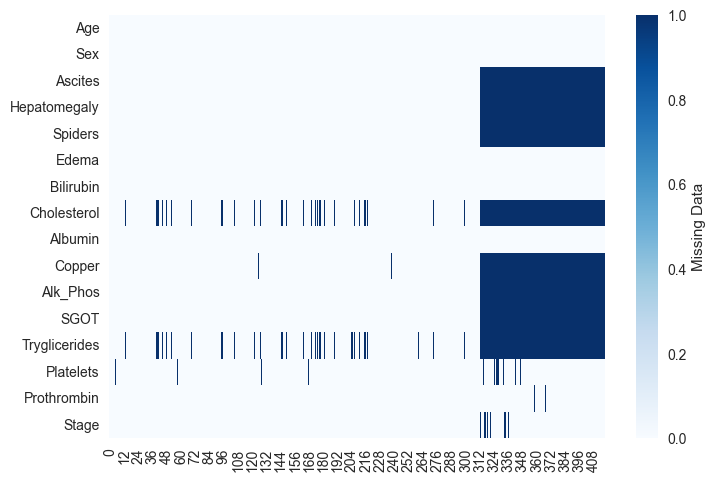

In [34]:
# Let's plot them
sns.heatmap(df.isnull().transpose(),
            cmap='Blues',
            cbar_kws={'label': 'Missing Data'})
plt.show()

You can see that when there are no values for Ascites, there are no values for Hepatomegaly, Spiders, Cholesterol, etc either.

Deleting the null values is not an option because I will lose 25% of my data, so we have to think in an imputation strategy. However, Stage is our target variable and I only have 6 missing values. I prefer not to impute the target variable, I will drop those cases.

#### For numerical data (Cholesterol, Copper, Alk_Phos, etc)

* I'll adopt the <b>MICE (Multivariate Imputation By Chained Equations)</b> strategy. In univariate imputer, the missing value is calculated using the same feature, whereas in multivariate imputer algorithms use the entire set of available feature dimensions to predict the missing value.

In [35]:
# Delete rows where Stage is not specified
df.dropna(subset=['Stage'], inplace=True)

# Impute numerical values using IterativeImputer
num_cols = df.select_dtypes(include=np.number).columns
imp = IterativeImputer(max_iter=10, random_state=0)
df[num_cols] = imp.fit_transform(df[num_cols])

print(f'After IterativeImputer, numerical columns ended with {df[num_cols].isna().sum().sum()} null values')

After IterativeImputer, numerical columns ended with 0 null values


#### For categorical data (Ascites, Hepatomegaly, Spiders)

* <b>MICE</b> only works with numerical variables, for categorical I'd use another algorithm with the same principle called <b>miceforest</b>, which handles categorical data automatically.

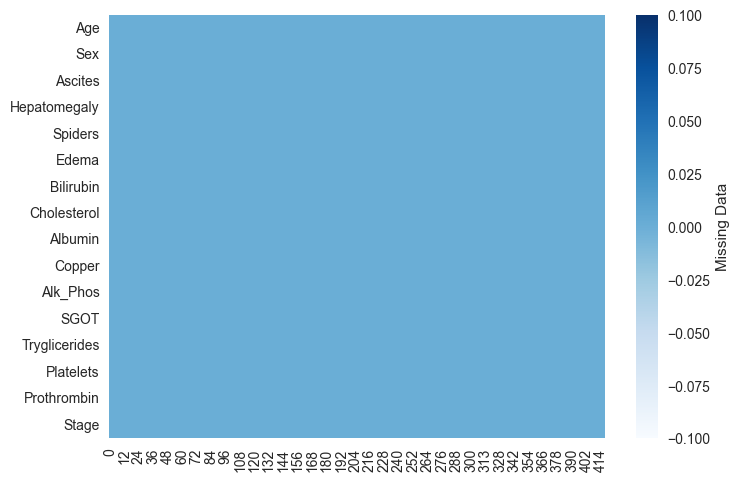

After miceforest imputation, dataset ended with 0 null values


In [36]:
# Impute categorical values using miceforest
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype('category')) # miceforest needs 'category' column types

# Create kernel
kernel = mf.ImputationKernel(
  df,
  datasets=4,
  mean_match_scheme=mean_match_shap, #slowest but most accurate, since dataset is small I can do it
  random_state=1
)

# Run the MICE algorithm for 5 iterations on each of the datasets
kernel.mice(5, n_jobs=-1)

# Return the completed dataset
df = kernel.complete_data(dataset=2)

# Plot after imputation
sns.heatmap(df.isnull().transpose(),
            cmap='Blues',
            cbar_kws={'label': 'Missing Data'})
plt.show()

print(f'After miceforest imputation, dataset ended with {df.isna().sum().sum()} null values')

Now with our datasete complete, we will head to EDA

## Exploratory Data Analysis 

First of all, let's check how many samples by Stage (our target variable) do we have. It's a multiple classification problem, our goal is correctly predict the stage of PBC and take actions, specially if we are in a reversible situation.

![Cirrhosis Stages](https://www.researchgate.net/profile/Amir-Ziaee/publication/343712197/figure/fig1/AS:925738282782720@1597724614341/Stages-of-liver-damage.jpg)

In [37]:
df['Stage'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

3.0    37.6%
4.0    35.0%
2.0    22.3%
1.0     5.1%
Name: Stage, dtype: object

Stage 1 is underepresented in the dataset, but that's not a major problem since it corresponds to a healthy liver. We want the model to learn the differences between Stages 2, 3 and 4 and this data does the job.

### Analysis of Numerical Variables

In [38]:
# Function 1 // 3 Chart Plot For Numerical Features

def plot_3chart_numeric(df, feature):
    
    # Custom graph creation
    fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    
    # Graph location on grid
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig) 

    # Histogram 
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    # Plot the histogram.
    sns.histplot(df.loc[:, feature],
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # QQ plot , es un grafico para ver que tan esta la dsitribucion de los datos en base a una normal
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    
    # Plotting qqplot
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Box plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    sns.boxplot(y = df.loc[:, feature], ax=ax3, color='#e74c3c')

    # Title for all the graphs
    plt.suptitle(f'{feature}', fontsize=18)

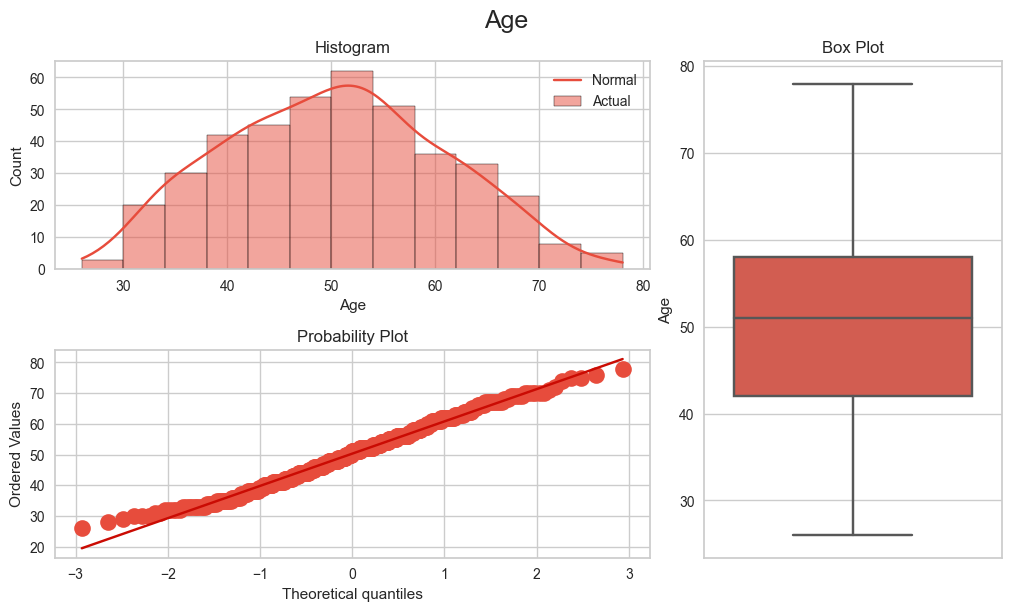

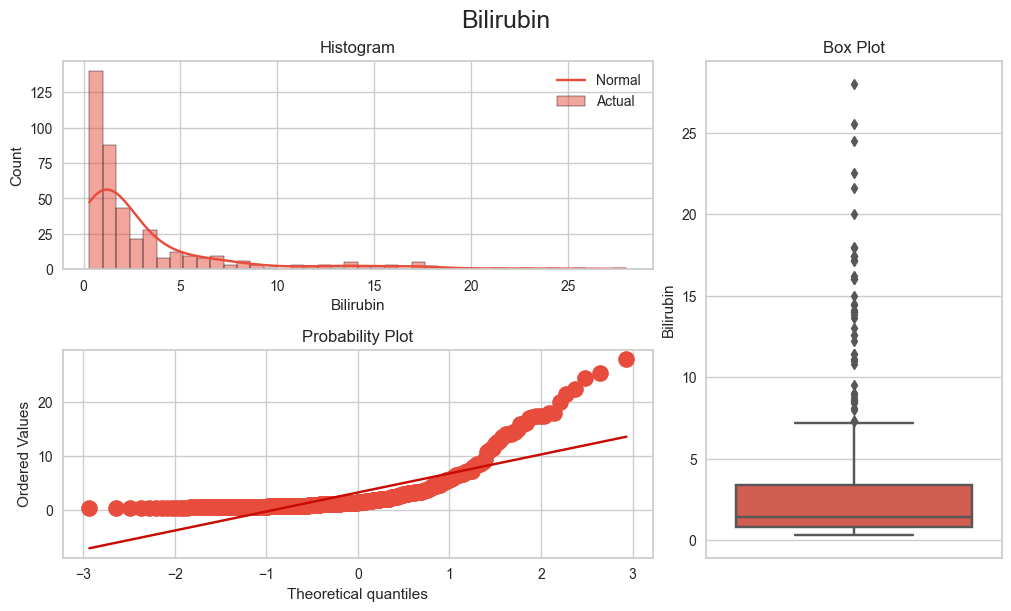

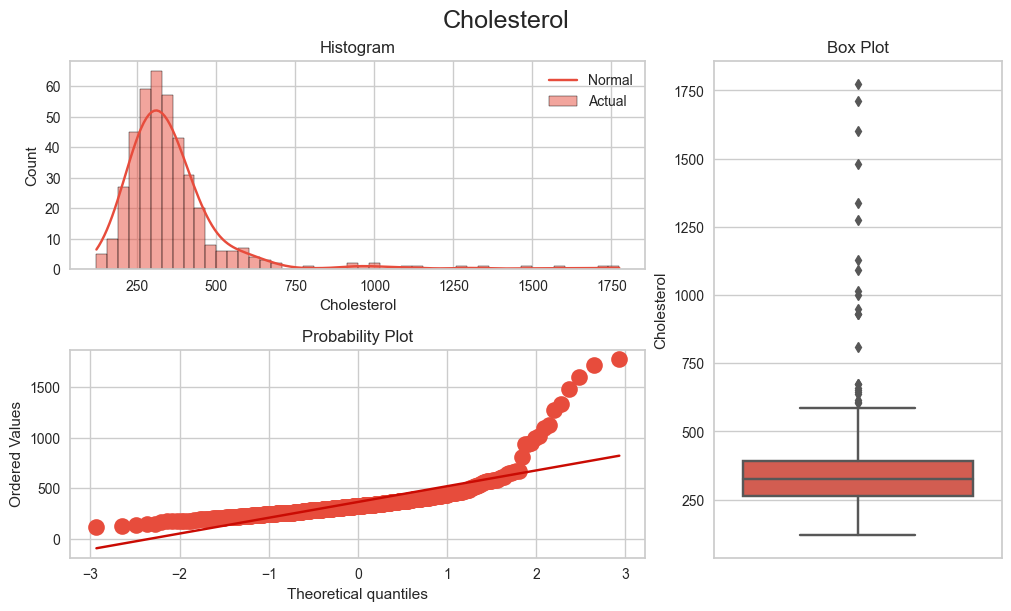

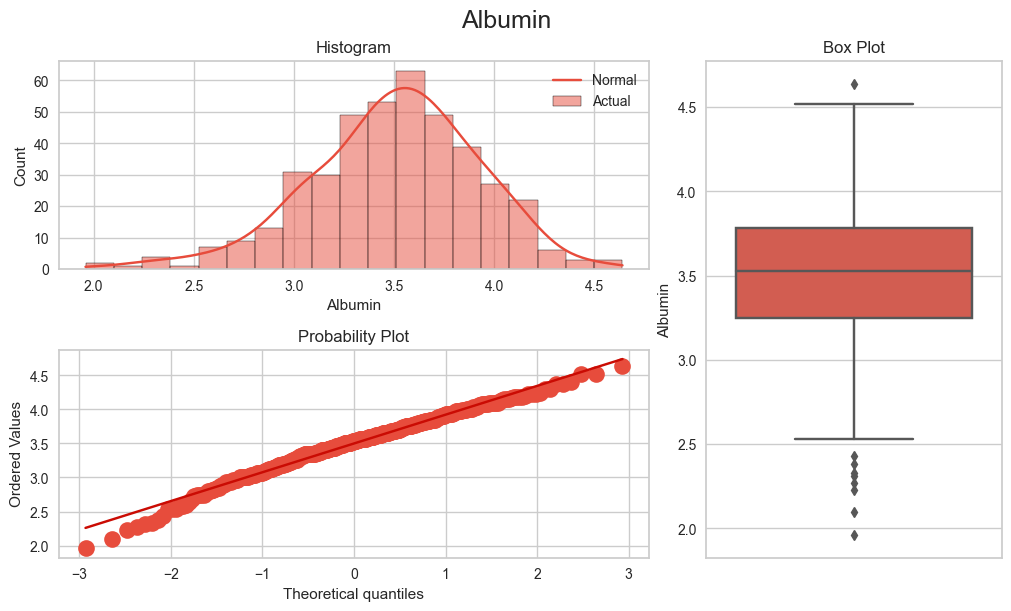

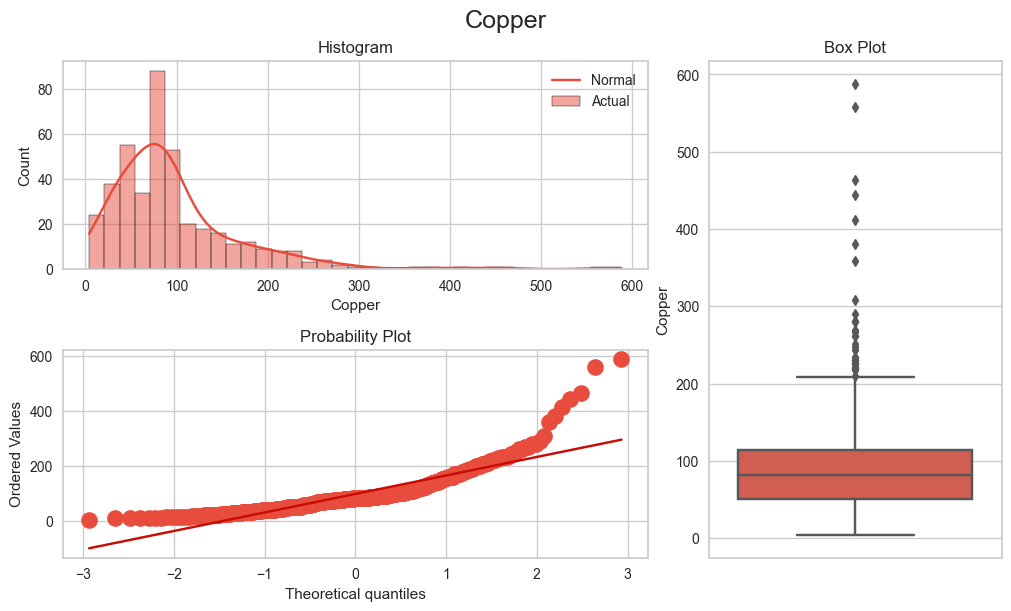

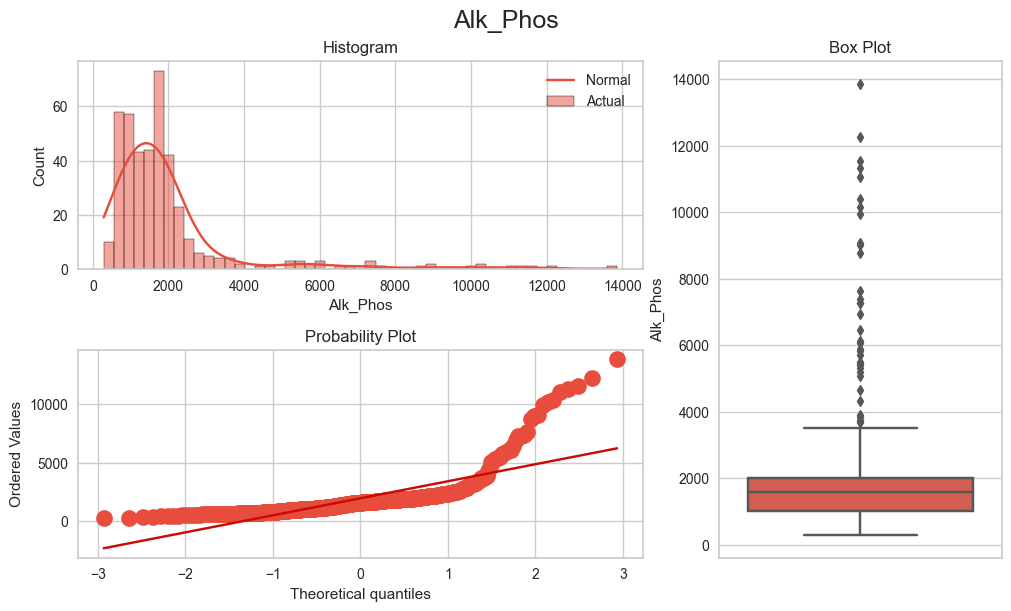

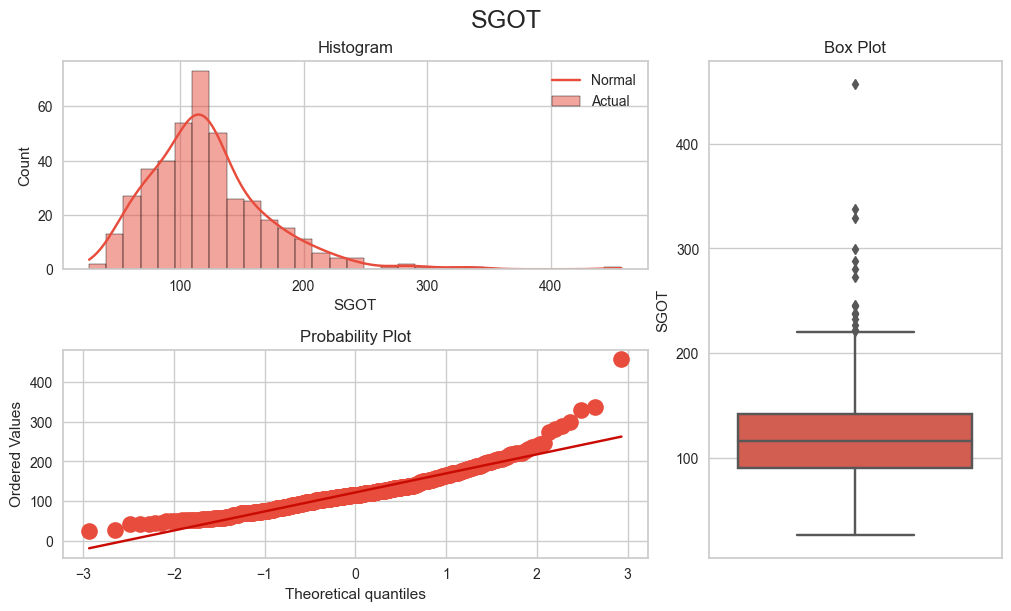

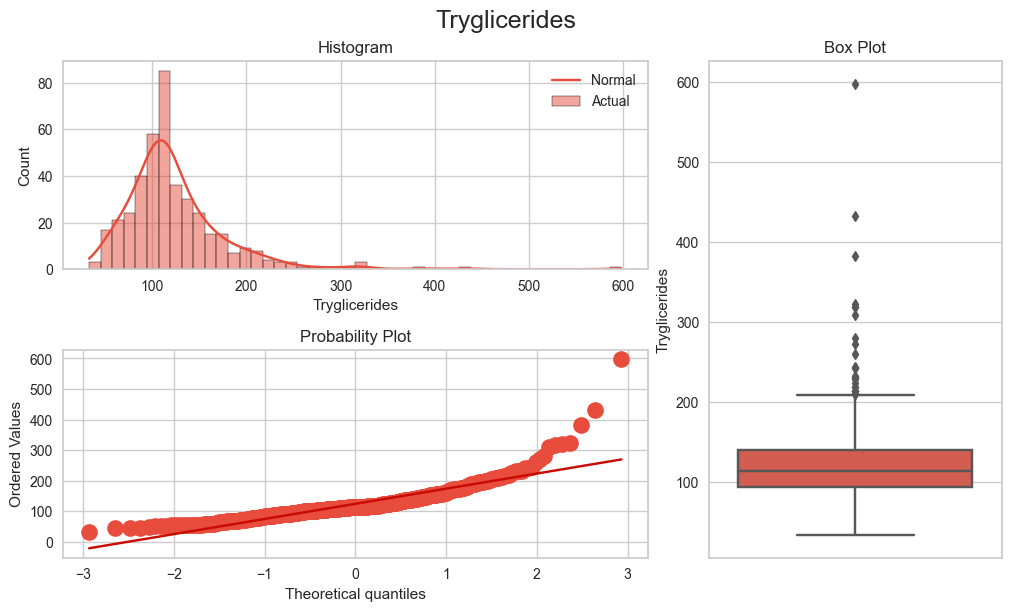

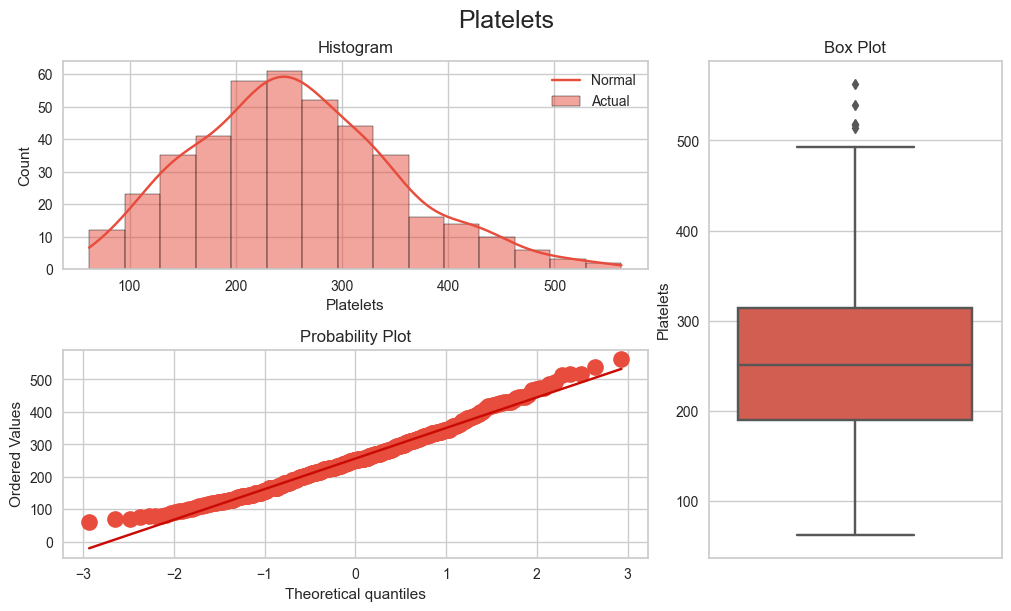

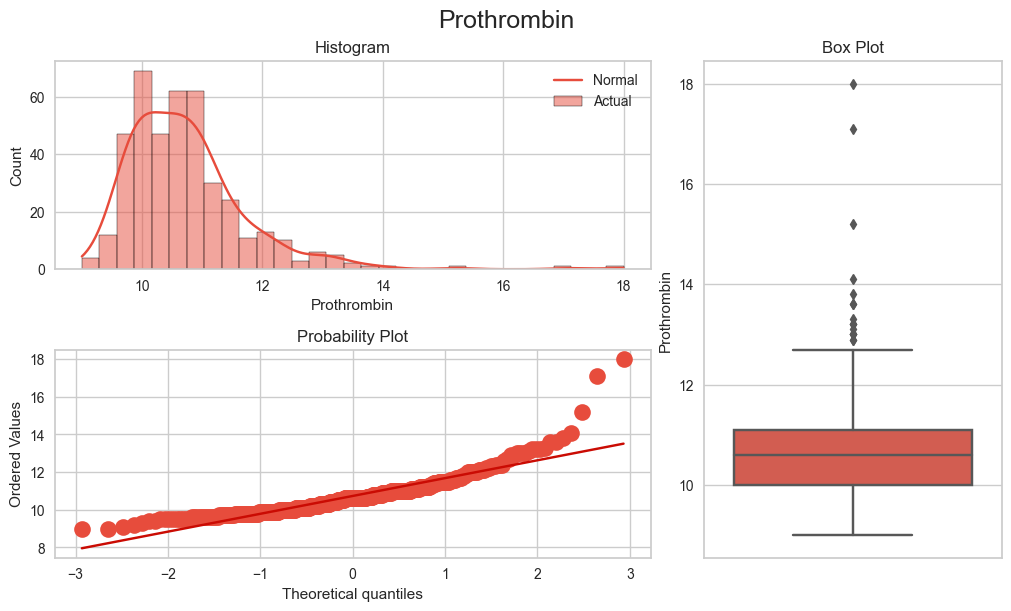

In [39]:
for num in num_cols[:-1]: #last column is Stage, we've already seen what we wanted to see
  plot_3chart_numeric(df, num)

<b>Conclusions</b>:

* In most of the boxplots we see upper outliers (<code>Alk_Phos</code>, <code>Cholesterol</code> and <code>Billirrubin</code> the main examples) and some like <code>Albumin</code> have lower outliers.
* It is common to find this extreme values in advanced stages of pathologies, so I don't consider it a problem. However, due to the distribution and the different units used to measure each variable, transformation is mandatory,
* Histograms and QQ-Plots confirm the right and left skewed distributions. <code>Age</code> and <code>Platelets</code> are the only ones that look normal.

### Analysis of Numerical variables in relation with PBC's stage


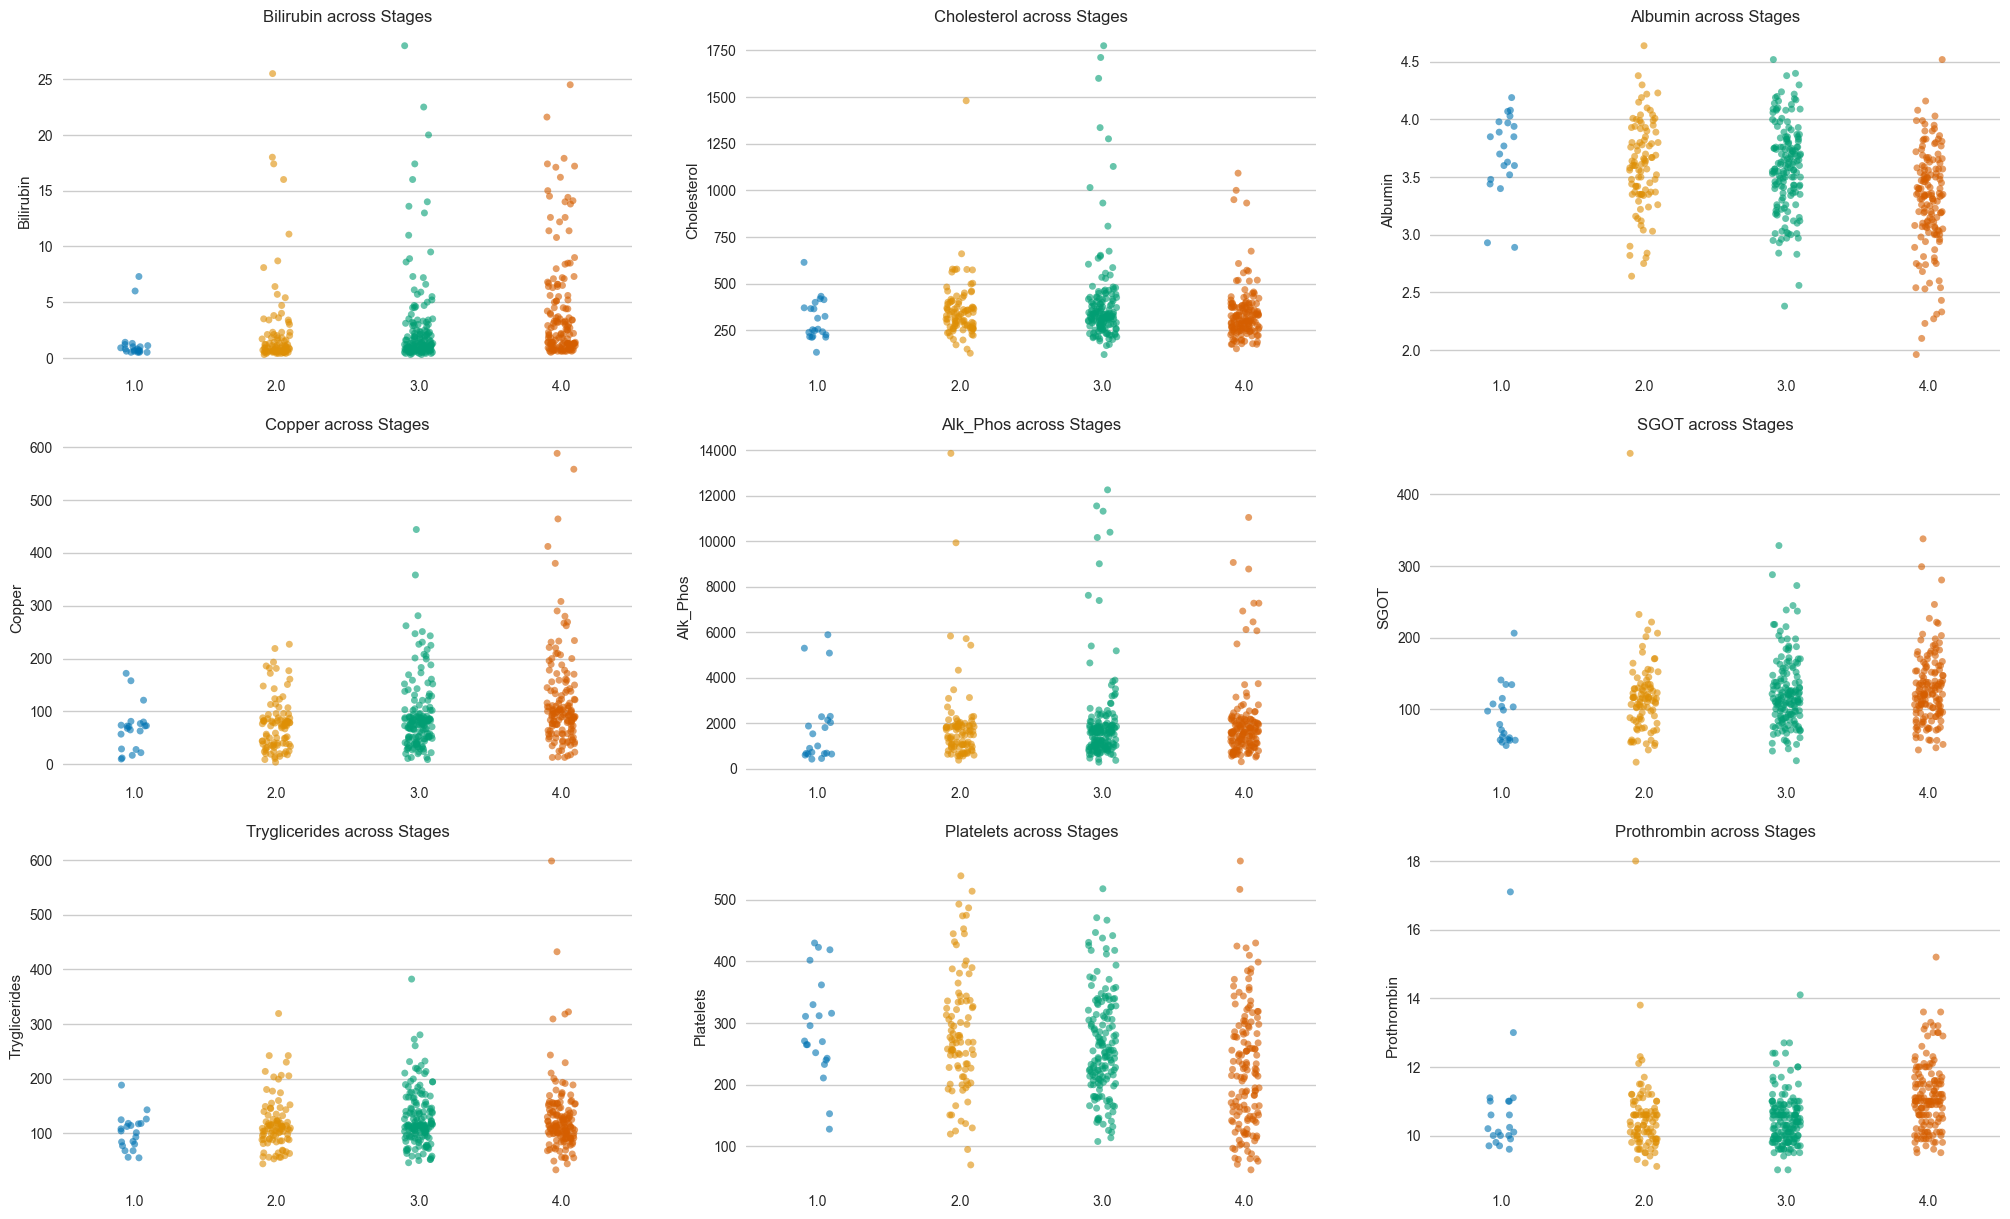

In [40]:
plt.figure(figsize=(25,15))
for idx, col in enumerate(num_cols[1:-1]):
    plt.subplot(3,3,idx+1)
    sns.stripplot(data=df, y=col,
                   x='Stage',
                   jitter=True,
                   dodge=True,
                   marker='o',
                   alpha=0.6,
                   palette='colorblind') #btw, i'm colorblinded
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(f'{col} across Stages')

<b>Conclusions</b>:

* When plotting the numerical variables in relation with PBC's stage, we see that <code>Platelets</code> and <code>Albumin</code> gives us the most valuable information.
* We could add <code>Prothrombin</code>, <code>Bilirrubin</code> and <code>Copper</code> as another markers.


### Analysis of Categorical variables

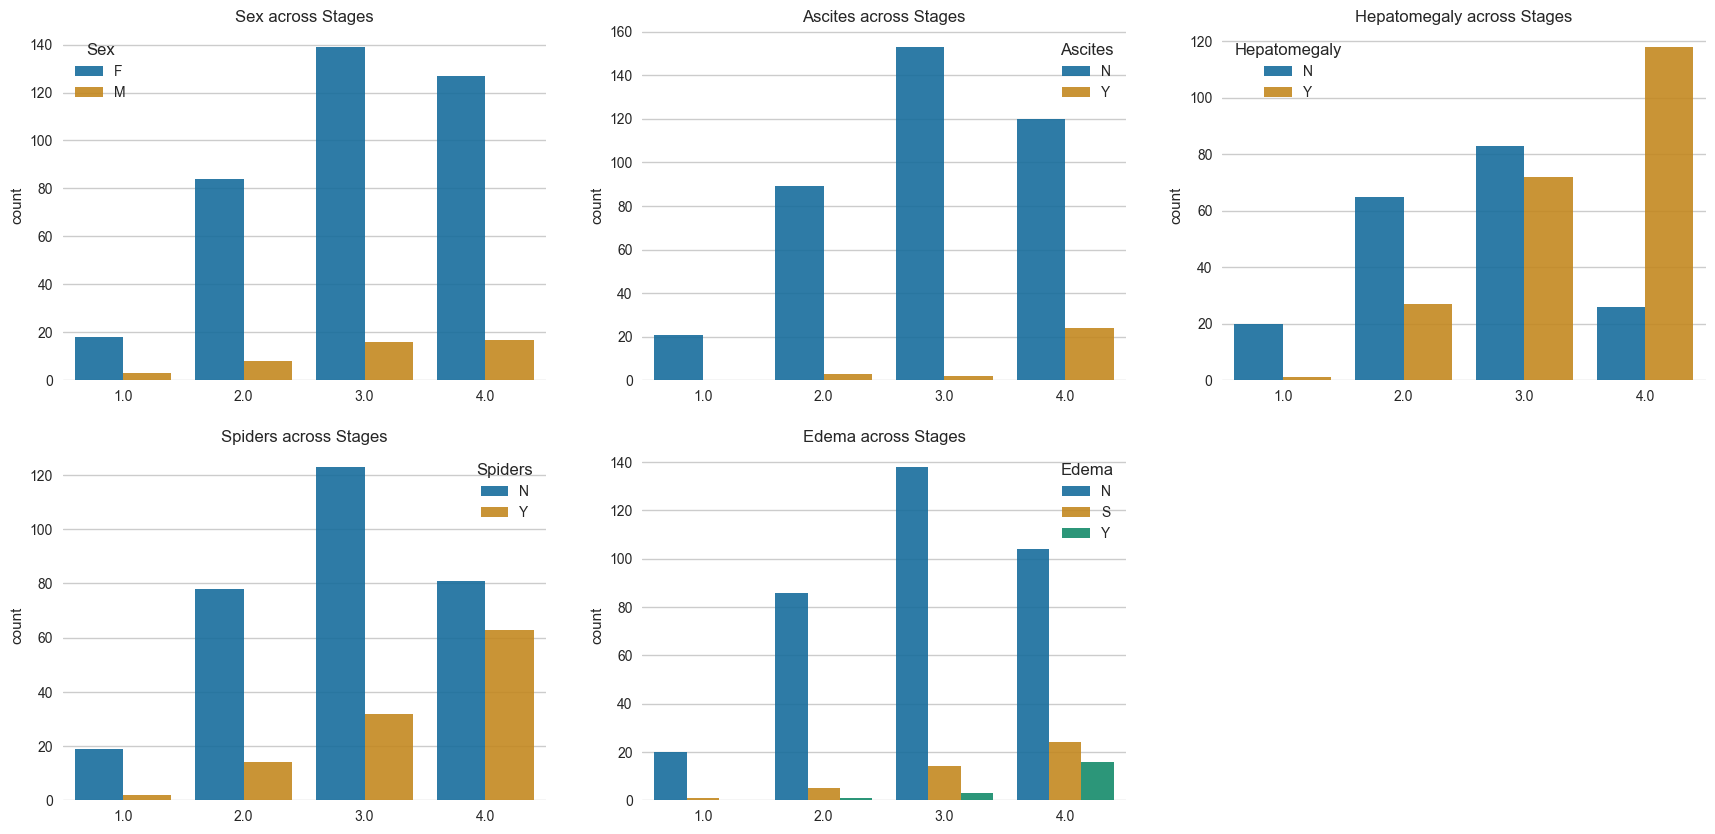

In [41]:
plt.figure(figsize=(21.2,10))
for idx, col in enumerate(cat_cols):
    plt.subplot(2,3,idx+1)
    sns.countplot(data=df, x='Stage', hue=col, palette='colorblind', alpha=0.9)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(f'{col} across Stages')

<b>Conclusions</b>:
* <code>Hepatomegaly</code> clearly gives me a lot of information about which stage I'm in, followed by <code>Spiders</code>.
* <code>Ascites</code> and <code>Edema</code> are good predictors for Stage 4 and not so good for the other stages.

## Modeling

In [42]:
# Define a subset with the variables chosen from EDA
df2 = df[['Sex','Age', 'Bilirubin','Copper','Prothrombin', 'Platelets', 'Albumin', 'Hepatomegaly', 'Ascites','Spiders', 'Edema','Stage']]

In [43]:
# Select X and y
X = df2.drop('Stage', axis=1)
y = df2['Stage']

# Step 1
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Transformations

In [44]:
# Step 2 - Transformations

# Identification of numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64','int']).columns.to_list()
cat_cols = X.select_dtypes(include=['object','category']).columns.to_list()

# Transformation for numerical variables (using Pipeline)
numerica_transformer = Pipeline(
                        steps=[('minmax', MinMaxScaler()) # many outliers
                              ])

# Transformation for categorical variables (using Pipeline)
categorica_transformer = Pipeline(
                            steps=[('ordinal', OrdinalEncoder(categories='auto'))]
                          )

# Pipeline Preprocessor Creation
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numerica_transformer, numeric_cols),
                        ('cat', categorica_transformer, cat_cols),
                    ],
                    remainder='passthrough'
                )

In [45]:
# Pipeline Preprocessor Training
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('minmax', MinMaxScaler())]),
                                 ['Age', 'Bilirubin', 'Copper', 'Prothrombin',
                                  'Platelets', 'Albumin']),
                                ('cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Hepatomegaly', 'Ascites', 'Spiders',
                                  'Edema'])])

In [46]:
# Pipeline Preprocessor Transformation
X_array_enc = preprocessor.transform(X_train)
columns_enc = X_train.select_dtypes(exclude='object').columns
X_train_enc = pd.DataFrame(X_array_enc, columns=columns_enc, index=X_train.index)

X_array_enc_test = preprocessor.fit_transform(X_test)
columns_enc_test = X_test.select_dtypes(exclude='object').columns
X_test_enc = pd.DataFrame(X_array_enc_test, columns=columns_enc_test, index=X_test.index)

### Evaluate best algorithm

Let's try with 3 algorithms and see which one has the best performance:
* Logistic Regression
* RandomForest
* XGBoost

It is a good practice to evaluate classification models using repeated stratified k-fold cross-validation. The stratification ensures that each cross-validation fold has approximately the same distribution of examples in each class as the whole training dataset.

We will use 3 repeats with 10 folds, and evaluate model performance using classification accuracy and F1-Score.


In [47]:
# Label Encoding for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

In [48]:
# Three models
rfc = RandomForestClassifier(n_jobs=-1, random_state=41)
xgbc = XGBClassifier(n_jobs=-1, random_state=41, objective='multi:sofprob', tree_method='hist')
lr = LogisticRegression(n_jobs=-1, random_state=41)

# Dictionary to store results
results = {}

# Define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Dictionary to store results
results = {}

# Iterate through models
for model in [rfc, xgbc, lr]:
    model.fit(X_train_enc, y_train_enc)
    y_pred = model.predict(X_test_enc)

    CV_scores = cross_val_score(model, X_train_enc, y_train_enc, cv=10, n_jobs=-1,scoring='accuracy')
    
    results[model.__class__.__name__] = { 'accuracy score_train': f'{CV_scores.mean():.5f} ± {CV_scores.std():.2f}',
                                          'accuracy score_test': accuracy_score(y_test_enc, y_pred),
                                          'f1_score': f1_score(y_test_enc, y_pred, average='weighted'),
                                          }

In [49]:
# Summary results
summary = pd.DataFrame.from_dict(results, orient='index')
summary

,accuracy score_train,accuracy score_test,f1_score
RandomForestClassifier,0.50456 ± 0.10,0.556452,0.544008
XGBClassifier,0.45197 ± 0.06,0.580645,0.580572
LogisticRegression,0.48990 ± 0.10,0.516129,0.494201


Looking at the score_test, best algorithm is <b>XGBClassifier</b>. Let's see if we can improve it's performance. 

### Hyperparameter optimization

In [60]:
# Params to tune
num_estimators = np.linspace(100, 150, num = 20, endpoint = True).astype(int)
max_depth = random.sample(range(2, 5), 1)
learning_rate = np.arange (0.01, 0.05, 0.05)
booster = ['dart','gbtree']
n_estimators = range(25, 45, 5)
subsample = np.arange(0.5, 0.8, 0.05)
eval_metric = ['merror','mlogloss']

# Global params
params_global = {'booster': booster,
                 'num_estimators': num_estimators,
                 'max_depth': max_depth, 
                 'learning_rate': learning_rate,
                 'eval_metric' : eval_metric,
                 'n_estimators' : n_estimators,
                 'subsample' : subsample
                 }

In [61]:
# Random Search tuning
tuning = RandomizedSearchCV(xgbc, params_global, cv=5, n_jobs=-1, refit=True, verbose=0, n_iter=50, random_state=12)

# Training
tuning.fit(X_train_enc, y_train_enc)

# Model Selection
best_model = tuning.best_estimator_

# Define metric
metrics_test = accuracy_score(y_test_enc, best_model.predict(X_test_enc))

# Print results
print(f'Model Train Accuracy: {tuning.best_score_:.4f}')
print(f'Model Test Accuracy: {accuracy_score(y_test_enc, best_model.predict(X_test_enc)):.4f}')
print(f'Model F1-Score: {f1_score(y_test_enc, best_model.predict(X_test_enc), average="weighted"):.4f}')

[18:37:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Model Train Accuracy: 0.4932
Model Test Accuracy: 0.6532
Model F1-Score: 0.6286


In [62]:
# Best params
tuning.best_params_

{'subsample': 0.55,
 'num_estimators': 123,
 'n_estimators': 40,
 'max_depth': 4,
 'learning_rate': 0.01,
 'eval_metric': 'mlogloss',
 'booster': 'gbtree'}

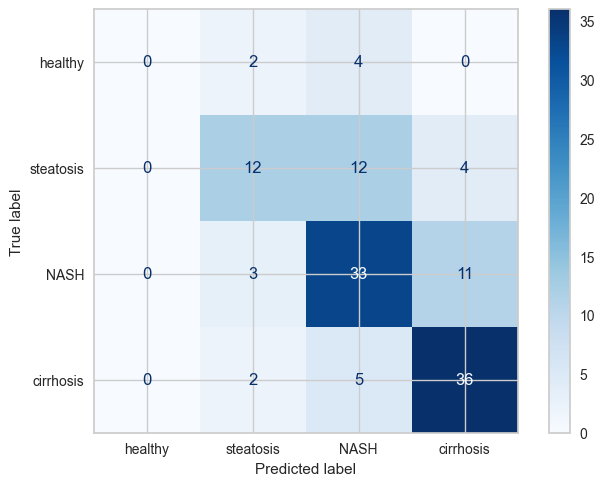

In [64]:
# Confusion matrix
y_pred = best_model.predict(X_test_enc)
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, display_labels=['healthy','steatosis','NASH','cirrhosis'], cmap='Blues')
plt.show()

<b>Conclusions:</b>
* We have very good performance on Stage 4 (cirrhosis) and very bad performance on Stage 1 (healthy liver). Althoug none of the healthy livers are being classified as Stage 4 (irreversible condition).
* Stage 2 (steatosis) is less accurate and many cases are missclassified as Stage 3 (NASH). However, we are still talking about a reversible condition, the real problem are the 4 cases that fall under cirrhosis and fortunately is a low number.
* For Stage 3 we have good performance but there is room from improvement.

C:\Users\juanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


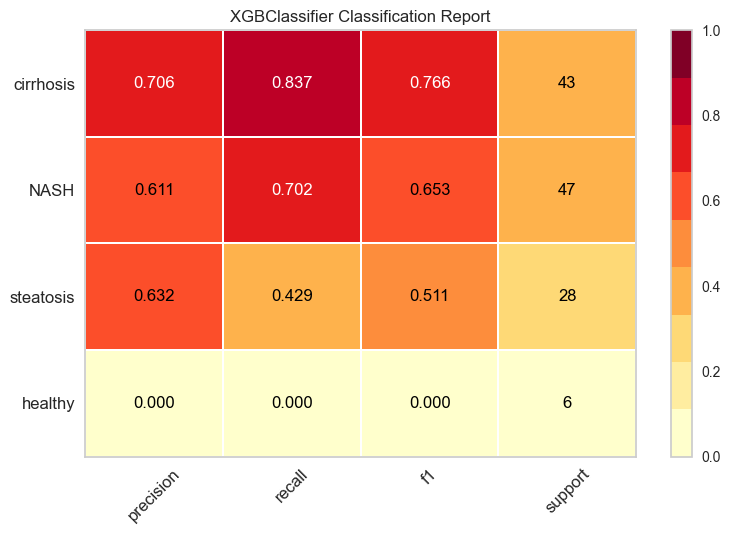

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [65]:
#Classification Report
visualizer = ClassificationReport(best_model, classes=['healthy','steatosis','NASH','cirrhosis'], support=True)

visualizer.fit(X_train_enc, y_train_enc)        # Fit the visualizer and the model
visualizer.score(X_test_enc, y_test_enc)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

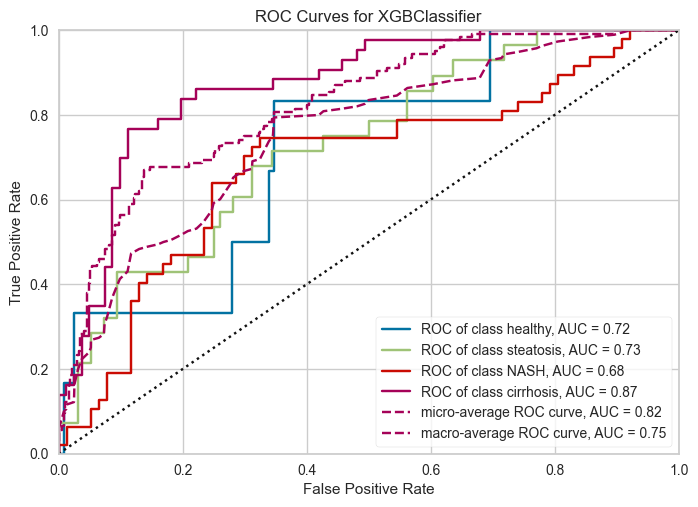

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['healthy', 'steatosis', 'NASH', 'cirrhosis'],
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=Fa...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.01, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=40, n_jobs=-1, num_estimators=123,
                               num_parallel_tree=1, objective='multi:softprob',
                               predictor='auto', random_state=41, ...))

In [66]:
# Let's check the ROC AUC curve
roc_auc(best_model, X_train_enc, y_train_enc, X_test=X_test_enc, y_test=y_test_enc, classes=['healthy','steatosis','NASH','cirrhosis'])

## Conclusions

* The final model gives me an F1-Score of <b>0.6286</b> and an accuracy <b>0.6532 (65.32%)</b>.
* Though it is not an impressive number, it performs very good on Stages 3 and 4 (NASH and cirrhosis) of PBC. As we've seen earlier, once we reach Stage 4 disease is irreversible and potentially lethal.
* It has a weaker performance on Stages 1 and 2, it's very poor at predicting healthy livers, but those cases were classified as reversible. Steathosis is a bit better. 
* Remember that a dummy model would have 1/4 (25%) of chance of correctly diagnosing stage. We are increasing this chance by a lot without the need of a liver biopsy: an invasive technique, stressful to the patient and not at all free of risk.

### How we could improve it?

* Collect more samples. A robust machine learning model is built at least with 1000 cases.
* In the past years, Antimitochondrial antibody (AMA) has shown a strong correlation with PBC. Adding that measure to the dataset will increase the predictive power of the model.